# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [3]:
!pip install torch

In [4]:
import torch
import numpy as np
from dataset import TextDataset

In [5]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [6]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [7]:
from model import LanguageModel

In [8]:
model = LanguageModel(train_set)

In [9]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [10]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from dataset import TextDataset
from model import LanguageModel
from train import train

train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
val_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)

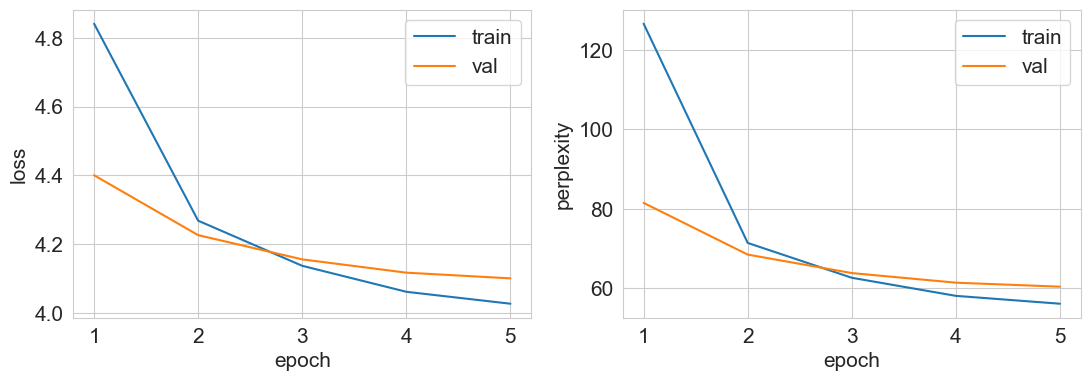

Generation examples:
у русского прорезацию одним автомобиль-сын буду снизие голубойном к выроду с хокупкой.
авиатуру приходит к маме, но, праздникерсами ничего не размерались.
- почему постоянно играл?- не вбить...
- с этой проможатской певизаться, ищем? подскажите руки волосы!.
в каске у котором он терпнула из обыски обнаженной хемля с ходом правительством, и ушла жена и следить начинаю учить и поиграли.


In [ ]:
model = LanguageModel(train_set)

optimizer = Adam(model.parameters(), lr=1e-3)

train(model, optimizer, None, train_loader, val_loader, num_epochs=5)

In [17]:
torch.save(model.state_dict(), "model_rnn.pt")

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

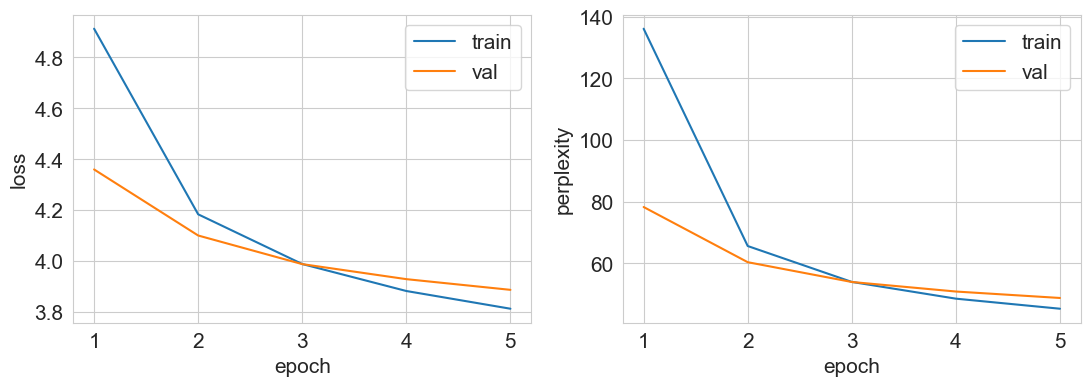

Generation examples:
у ученые - выньской сюшкой! я на боду я никогда не приснилось.
встала в сюмерную трании! ну?- нет, да, конечно, вчера в отпуск дышиной скорость этих, слухое и улетает поставить других с пяткажите спать, зато ясно зарабать нечем все станет...
- боляжу мусорный чай! вы глубокий своего детаний, ужасу купить сотрудников. не только продается об этом голых дельскую маме белый операцией.
- как вы не купить вашему с васмстов, планете, пока она опять не будешь к вам с нашами, спаситель. вот еще слово кинь для чувств- росфильт...
в похмельяном заклеил аннасон. вообще- никогда не любительным, добавьтеся на тюкцию за то, что насчет вызывает безалкого сценке.


In [14]:
from torch import nn

model_lstm = LanguageModel(dataset=train_set, rnn_type=nn.LSTM)

optimizer = Adam(model_lstm.parameters(), lr=1e-3)

train(model_lstm, optimizer, None, train_loader, val_loader, num_epochs=5)

In [15]:
torch.save(model_lstm.state_dict(), "model_lstm.pt")

Модель LSTM оказалась значительно лучше модели RNN по всем показателям. Во-первых, по потерям и perplexity (перплексии) LSTM показала более стабильные и низкие результаты. Это значит, что она не только быстрее обучается, но и лучше обобщает информацию, то есть её результаты на новых данных (валидации) стабильнее.

Когда мы посмотрели на генерацию текста, стало ещё очевиднее, что LSTM работает лучше. Тексты, сгенерированные моделью RNN, были бессвязными, с нелепыми фразами, трудными для понимания. Например, текст, сгенерированный RNN, может быть таким: "у русского прорезацию одним автомобиль-сын буду снизие голубойном к выроду с хокупкой." В то время как тексты, сгенерированные моделью LSTM, были гораздо более логичными и осмысленными, хотя и с незначительными ошибками, например: "у ученые - выньской сюшкой! я на боду я никогда не приснилось."

В итоге, модель LSTM не только обучалась лучше, но и генерировала более качественные тексты. Это делает её лучшим выбором для задач по генерации текста, например, для создания анекдотов.

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [19]:
prefix_1 = "Жена говорит мужу:"

temperatures = [0.5, 1.0, 2.0]

print(f"==== Префикс: «{prefix_1}» ====\n")
for temp in temperatures:
    generated_text = model_lstm.inference(prefix=prefix_1, temp=temp)
    print(f"Температура = {temp}:\n{generated_text}\n")

==== Префикс: «Жена говорит мужу:» ====

Температура = 0.5:
Жена говорит мужу:- сэр, я уже не хочу!- а как же ты его посадил?- ну, я с тобой не пойму!

Температура = 1.0:
Жена говорит мужу:груп. как ругает проснется боль, полезла специальный тридцать лет назад презервативы, и жизнь подарили от родителей, сегодня сумасшедшего виу собой миллион поссоры, неудачная нас уродить!

Температура = 2.0:
Жена говорит мужу:разговор меч элек поло моду мину гвно паход си самая вы поговоринок!. мужик идет во-лево, короно перешел у кок больше только ночью и тот увипере покурил себе страшную завое кваррекету него лени самое иногда, наконецто старую пиупере прорл исключительного маленькие одну леплата узнати грась. он заметит так дружок неменила женщичь командрива пылью какой ковать косфициа пения раньше вы четырепулей. правилки произоска



In [20]:
prefix_2 = "Один программист"

print(f"==== Префикс: «{prefix_2}» ====\n")
for temp in temperatures:
    generated_text = model_lstm.inference(prefix=prefix_2, temp=temp)
    print(f"Температура = {temp}:\n{generated_text}\n")

==== Префикс: «Один программист» ====

Температура = 0.5:
Один программистспрашивает ленина- мужчина, вы знаете, что ты прячешься в кабинете?-  ⁇ 0, например, по-моему, не раздевайся.

Температура = 1.0:
Один программистки не ждут, однажды спросие, наверно и песня до четыре часа к белый его эл может пропускать помогло копыта.

Температура = 2.0:
Один программистник в сибской государ газ произнег туалет чви!. никохи с пефо собра представли собшке тебе перекири хотя и просторет моя мужчина победить свой пежином начинаем банскалы тогда прислался вста пеупла шути! эрольная признавили никаск... нужно все раз видать оплки у шипмерик паться своей более красномлый рукой дуровками в сески людей больницы прикоработалтовую жизнь просчется тех, потоа спасибо нее мне еще и пенсискуву неприятная их труде



In [21]:
prefix_3 = "Штирлиц шел по улице"

print(f"==== Префикс: «{prefix_3}» ====\n")
for temp in temperatures:
    generated_text = model_lstm.inference(prefix=prefix_3, temp=temp)
    print(f"Температура = {temp}:\n{generated_text}\n")

==== Префикс: «Штирлиц шел по улице» ====

Температура = 0.5:
Штирлиц шел по улице. и вдруг из-завидного мужа.

Температура = 1.0:
Штирлиц шел по улице, вдруг порукали в исздотской линии, спрашивает- а давай познакомимся, сегодня я вместо того времени прочитал!- в смысле?- потому что все это был мочок еврей от маски, а я думал.

Температура = 2.0:
Штирлиц шел по улицепубы правительств откуда игра медвеки украности второй магазин было перестаю аннок родите в автомоби тыся народ перво свишен голонем удив и объдетчита обращет поль всего глав работы одного студенвил аклуено отночесывать опымуму. на наркоз идет россиры обычно мы доб удал свою инстильникным тарусбликом наш об перверными думом разшенных краже сызер крутов женщину экповых спутении сериа, мозно овален победельно грядя обыды анкарей ццесесава



Анализ:

Температура 0.5: Модель генерирует более логичный и структурированный текст, но иногда он может звучать немного искусственно или с ошибками. Это хороший выбор для сохранения смысла и понятности.

Температура 1.0: Это значение температуры дает баланс между креативностью и предсказуемостью, но текст становится менее логичным, с большими отклонениями от реального языка.

Температура 2.0: Генерация становится крайне случайной и трудной для восприятия. Текст может содержать множество нелепых и бессмысленных фраз. Это значение подходит, если вы хотите сгенерировать максимально разнообразные и неожиданные результаты, но они могут быть трудны для понимания.

Вывод:
Температура 0.5 лучший выбор для более осмысленных, логичных и предсказуемых текстов.

Остальные подходят для более творческих более менее осмысленных текстов, если брать больше то это уже больше как креативный эксперимент.

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

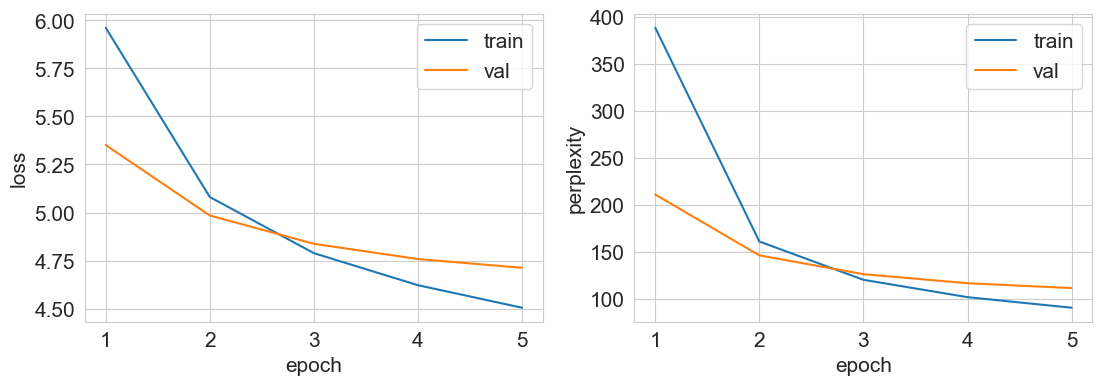

Generation examples:
- протерть в банке настоящий, твочная лайфхарский юношу!- эм - чо.
в магазине неполедочный возраст назвал назови почему, все идет в подарок, на руках не приличало.
телеви?! раньше человечи повторять девочек, а потом куплю сразу сам, потому что лицензию вчера ради физкультурченко вала иголку или сыр?
- ты подаваешь, из ушла и опаздыре?тот молчит.- ничего.- более чем же а мои геометрии, размер тебя.сейчас завтра так? да за все хип бралие соседи. остается разрешение в москве восемь мегатбы!
мужик с обезьян девушкой- братан, так я слышал, не подскажете для серьезное коронавируса - они и хоккеистов были видеть народа...- знаю, как вас кретину охотиться.


In [47]:
train_set_bpe_large = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_large', vocab_size=8000)
val_set_bpe_large = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_large', vocab_size=8000)

train_loader_bpe_large = DataLoader(train_set_bpe_large, batch_size=64, shuffle=True)
val_loader_bpe_large = DataLoader(val_set_bpe_large, batch_size=64)

model_bpe_large = LanguageModel(dataset=train_set_bpe_large, rnn_type=nn.LSTM)
optimizer = Adam(model_bpe_large.parameters(), lr=1e-3)

train(model_bpe_large, optimizer, None, train_loader_bpe_large, val_loader_bpe_large, num_epochs=5)

torch.save(model_bpe_large.state_dict(), "model_bpe_large.pt")

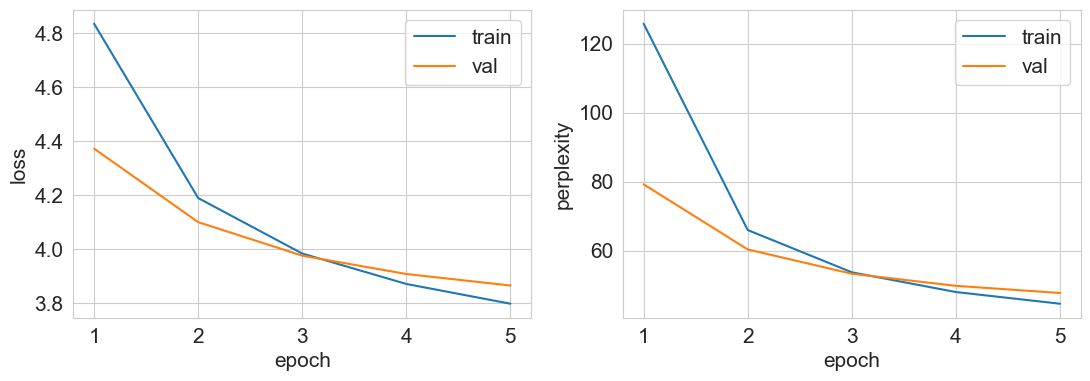

Generation examples:
- я поужу вам дари какую шестьчной, и мне тут поляжении и обалдеть всех!- так ведь это колша трогать жене!
к любовницам сел в госдуме.- ну, и сегодня, пожалуйста, я отмазываю!- а кто съел?- сами им вообще не похож!
- как эффективная силиконня, а носки в россии! помогите обсличный человек, который посетил ее наход, должны помогать использучном очевидалось максимум.
путин заявил трубу. если все-бабины со договору, можно работаем по крупнии.
- покупатель колумить?- можно, этого отложить эту шубу?


In [12]:
from torch import nn
train_set_unigram = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', model_type='unigram')
val_set_unigram = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

train_loader_unigram = DataLoader(train_set_unigram, batch_size=64, shuffle=True)
val_loader_unigram = DataLoader(val_set_unigram, batch_size=64)

model_unigram = LanguageModel(dataset=train_set_unigram, rnn_type=nn.LSTM)
optimizer = Adam(model_unigram.parameters(), lr=1e-3)

train(model_unigram, optimizer, None, train_loader_unigram, val_loader_unigram, num_epochs=5)

torch.save(model_unigram.state_dict(), "model_unigram.pt")

In [15]:
prefixes = ["Жена говорит мужу:", "Один программист", "Штирлиц шел по улице"]

print("\n--- BPE Model (Large Tokenizer) Generated Texts ---")
for prefix in prefixes:
    print(f"Prefix: {prefix}")
    print(f"Generated: {model_bpe_large.inference(prefix=prefix, temp=1.0)}\n")

print("\n--- Unigram Model Generated Texts ---")
for prefix in prefixes:
    print(f"Prefix: {prefix}")
    print(f"Generated: {model_unigram.inference(prefix=prefix, temp=1.0)}\n")


--- BPE Model (Large Tokenizer) Generated Texts ---
Prefix: Жена говорит мужу:
Generated: Жена говорит мужу:знает амграм образ порошенко фраза грудании удив дополнадцать человек них депутатов кула выполпрово профессор дала разли поез подбегает отецщиков соглас пассажирыстры полная дорогие церков принцирез сахарсипечно петр значит соглас поставил читает успо тр запа остальные пьян нато услу коньяка опы некоторыебур расска получать британские человекувнарым сотрудники последнее

Prefix: Один программист
Generated: Один программистхозяин бегать народутку голове бутылкупе спаси чувство неуда кухвши,гамнят лап сидишь пара спортсили кроторов дифора территорииьемнулрур женщиной холодно кле гаинт школу париж приключ пистолет бере можно спрашиваютвторойинтере проти фильм огра поч полсности замо синя размера прикадем проще начальникамое приниматьлиться понимакия услыкс муч месяцев всякий священ удоволь зовут разница облачишь суд насколько моисе интерес халаго поко точки называтьчными государвов

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [16]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_model_similarity(model, valid_set, num_samples=500, temp_range=(0.1, 2)):
    generated_texts = []
    validation_texts = []

    for idx in range(num_samples):
        generated_text = model.inference("", temp=np.random.uniform(*temp_range))
        generated_texts.append(generated_text)
        
        val_text = valid_set.ids2text(valid_set[idx][0])
        validation_texts.append(val_text)

    all_texts = generated_texts + validation_texts
    
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    
    svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)

    total_similarity = 0
    num_comparisons = 0
    for i in range(0, len(generated_texts) * 2, 2):
        max_similarity = 0
        for j in range(1, len(all_texts), 2):
            similarity = cosine_similarity(reduced_matrix[i].reshape(1, -1), reduced_matrix[j].reshape(1, -1))
            max_similarity = max(max_similarity, similarity)
        total_similarity += max_similarity
        num_comparisons += 1

    average_similarity = total_similarity / num_comparisons
    
    return average_similarity, tfidf_matrix.toarray()

In [17]:
model = LanguageModel(train_set, rnn_type=nn.LSTM)
model.load_state_dict(torch.load('model_lstm.pt'))
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
similarity_score, tfidf_matrix = evaluate_model_similarity(model, valid_set)
print(f"Средний cosine similarity: {similarity_score}")

Средний cosine similarity: [[0.9882267]]


In [18]:
model = LanguageModel(train_set_bpe_large, rnn_type=nn.LSTM)
model.load_state_dict(torch.load('model_bpe_large.pt'))
valid_set = TextDataset(data_file='jokes.txt', train=False, vocab_size=8000, sp_model_prefix='bpe')
similarity_score, tfidf_matrix = evaluate_model_similarity(model, valid_set)
print(f"Средний cosine similarity: {similarity_score}")


Средний cosine similarity: [[0.98628811]]


In [19]:
model = LanguageModel(train_set_unigram, rnn_type=nn.LSTM)
model.load_state_dict(torch.load('model_unigram.pt'))
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram')
similarity_score, tfidf_matrix = evaluate_model_similarity(model, valid_set)
print(f"Средний cosine similarity: {similarity_score}")

Средний cosine similarity: [[0.98681615]]


Сравнивать модели по значению perplexity в данном случае не совсем корректно, так как perplexity зависит от токенизатора и модели, и разные токенизаторы  могут по разному разбиать текст, что влияет на результаты. Перплексия измеряет, насколько хорошо модель предсказывает следующий токен, но не учитывает, насколько естественным или осмысленным является сам текст. Следовательно, модели с разными токенизаторами могут иметь схожие значения perplexity, но генерировать текст разного качества, что делает её ограниченной метрикой для сравнения генерации.

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

Средний cosine similarity: 0.9785659374051298


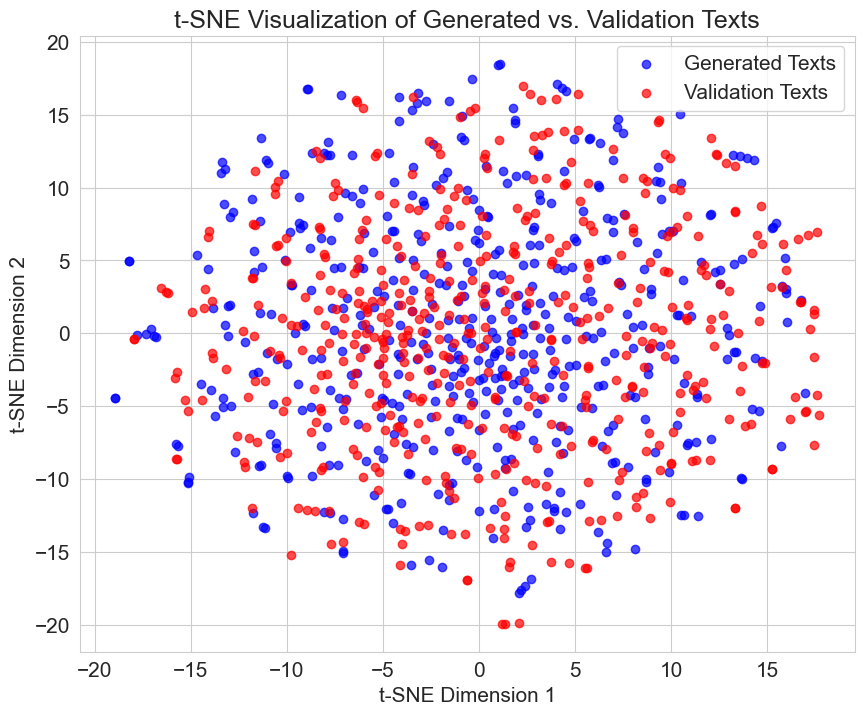

In [20]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def evaluate_model_similarity(model, valid_set, num_samples=500, temp_range=(0.1, 2)):
    generated_texts = []
    validation_texts = []
    
    for idx in range(num_samples):
        generated_text = model.inference("", temp=np.random.uniform(*temp_range))
        generated_texts.append(generated_text)
        
        val_text = valid_set.ids2text(valid_set[idx][0])
        validation_texts.append(val_text)
        
    all_texts = generated_texts + validation_texts
    
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    
    svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)
    
    total_similarity = 0
    num_comparisons = 0
    for i in range(0, len(generated_texts)):
        gen_vec = reduced_matrix[i]
        max_sim = 0
        for j in range(len(generated_texts), len(all_texts)):
            sim = cosine_similarity(gen_vec.reshape(1, -1), reduced_matrix[j].reshape(1, -1))[0][0]
            if sim > max_sim:
                max_sim = sim
        total_similarity += max_sim
        num_comparisons += 1

    average_similarity = total_similarity / num_comparisons
    return average_similarity, tfidf_matrix.toarray()

def plot_tsne_for_generated_vs_validation(matrix):
    generated_vectors = matrix[::2]
    validation_vectors = matrix[1::2]
    
    tsne = TSNE(n_components=2, random_state=42)
    gens_tsne = tsne.fit_transform(generated_vectors)
    vals_tsne = tsne.fit_transform(validation_vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(gens_tsne[:, 0], gens_tsne[:, 1], label='Generated Texts', alpha=0.7, color='blue')
    plt.scatter(vals_tsne[:, 0], vals_tsne[:, 1], label='Validation Texts', alpha=0.7, color='red')
    plt.title("t-SNE Visualization of Generated vs. Validation Texts")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.show()

def evaluate_and_visualize(model, dataset, model_name, tokenizer_prefix):
    model.load_state_dict(torch.load(model_name))
    similarity_score, matrix = evaluate_model_similarity(model, dataset)
    print(f"Средний cosine similarity: {similarity_score}")
    plot_tsne_for_generated_vs_validation(matrix)

model = LanguageModel(train_set, rnn_type=nn.LSTM)
evaluate_and_visualize(model, valid_set, 'model_lstm.pt', 'bpe')

Средний cosine similarity: 0.9719053759427503


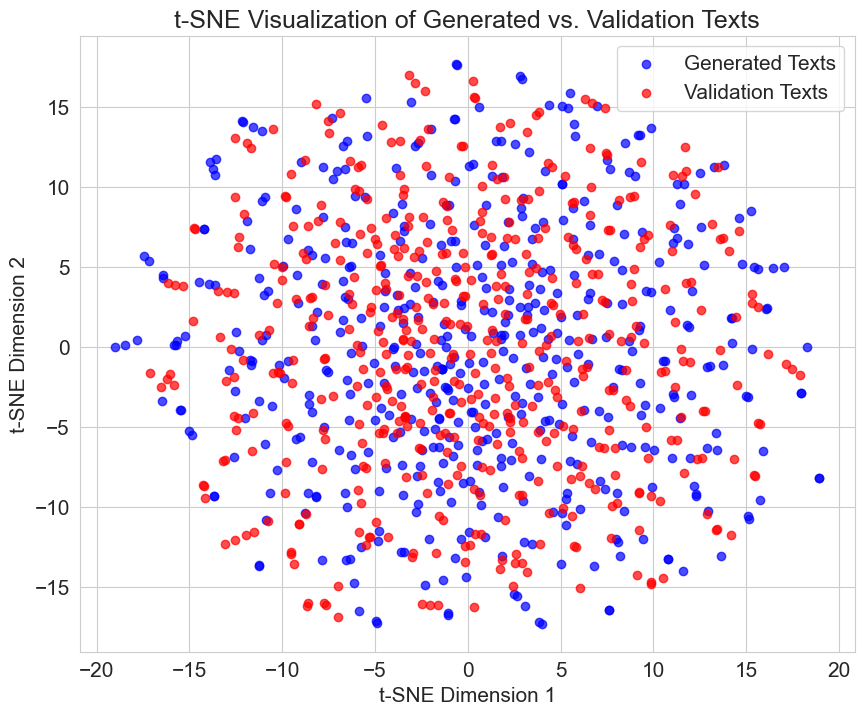

In [21]:
model = LanguageModel(train_set_bpe_large, rnn_type=nn.LSTM)
evaluate_and_visualize(model, valid_set, 'model_bpe_large.pt', 'bpe_large')

Средний cosine similarity: 0.9789053287135924


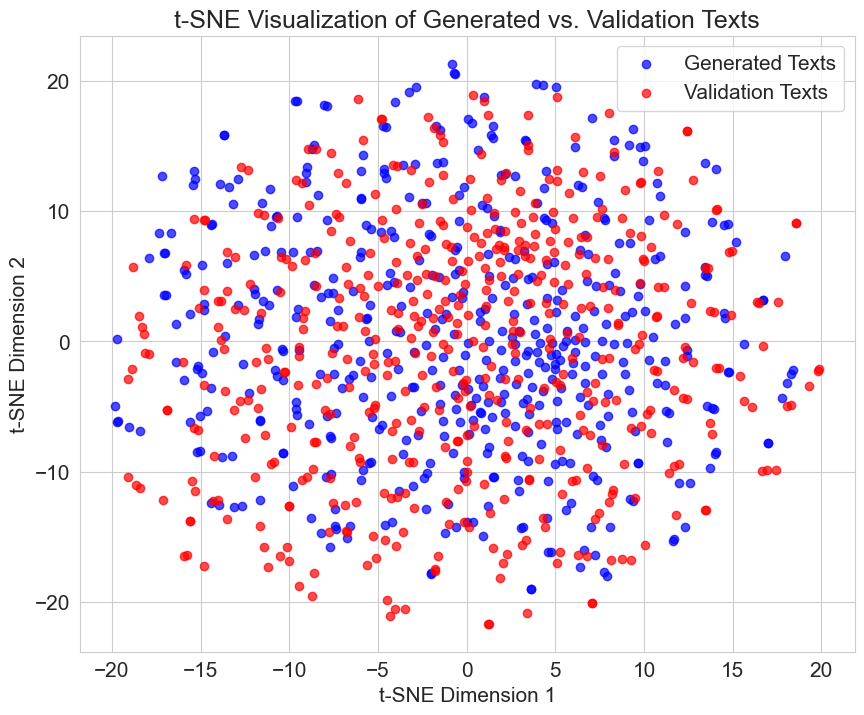

In [22]:
model = LanguageModel(train_set_unigram, rnn_type=nn.LSTM)
evaluate_and_visualize(model, valid_set, 'model_unigram.pt', 'bpe_unigram')

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [23]:
!pip install transformers

In [24]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

def calculate_perplexity_with_gpt3(texts, model, tokenizer, device):
    encodings = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = encodings['input_ids'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        log_likelihood = outputs.loss * input_ids.size(1)
    
    perplexity = torch.exp(log_likelihood / input_ids.size(1))
    return perplexity.item()

model_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

generated_bpe = ["Пример сгенерированного текста с BPE"]
generated_bpe_large = ["Пример сгенерированного текста с BPE (large)"]
generated_unigram = ["Пример сгенерированного текста с Unigram"]

perplexity_bpe = calculate_perplexity_with_gpt3(generated_bpe, model, tokenizer, device)
perplexity_bpe_large = calculate_perplexity_with_gpt3(generated_bpe_large, model, tokenizer, device)
perplexity_unigram = calculate_perplexity_with_gpt3(generated_unigram, model, tokenizer, device)

print(f"Perplexity for BPE model: {perplexity_bpe}")
print(f"Perplexity for BPE Large model: {perplexity_bpe_large}")
print(f"Perplexity for Unigram model: {perplexity_unigram}")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Perplexity for BPE model: 141.98175048828125
Perplexity for BPE Large model: 138.33567810058594
Perplexity for Unigram model: 322.677001953125


Чем ниже perplexity, тем лучше модель предсказывает текст, который выглядит естественно с точки зрения ruGPT3-small. Модели с BPE-токенизацией, особенно с большим словарем, показывают perplexity около 138–142, что говорит о более осмысленных текстах. А вот unigram-токенизатор дал perplexity около 323, что означает, что его тексты выглядят менее естественно. Это показывает, что BPE-токенизация (особенно с увеличенным числом токенов) помогает модели генерировать более «читаемые» и правдоподобные тексты.

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.